## Inversión Libre de Riesgo

In [1]:
pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gurobipy as gp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Datos de Entrada

Los siguientes datos de entrada se utilizan en el modelo:

- $S$: conjunto de acciones
- $\mu$: vector de rendimientos esperados
- $\Sigma$: matriz de varianza-covarianza
    - $\sigma_{ij}$ covarianza entre los rendimientos de los activos $i$ y $j$
    - $\sigma_{ii}$ varianza del rendimiento del activo $i$
- $r_f$: Rentabilidad Activo Libre de Riesgo

In [18]:
# Importar datos
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

# Tasa Libre de Riesgo a 10 Años (MCM) (se puede recuperar en https://si3.bcentral.cl/Siete/ES/Siete/Cuadro/CAP_TASA_INTERES/MN_TASA_INTERES_09/TMS_15/T311 a la fecha)
rf = (1 + 0.0556)**(1/12) - 1

## Formulación

El modelo maximiza el Sharpe-Ratio. Matemáticamente, esto resulta en un problema de optimización convexa con restricciones cuadráticas.

### Variables de Decisión y Cotas de las Variable

Las variables de decisión en el modelo son las proporciones de capital invertidas entre las acciones consideradas. El vector correspondiente de posiciones se denota por $x$, donde su componente $x_i$ representa la proporción de capital invertido en la acción $i$.

Cada posición debe estar entre 0 y 1; esto evita el apalancamiento y la venta en corto:

$$0\leq x_i\leq 1 \; , \;  i \in S$$

Adicionalmente, tenemos el nivel de inversión en el activo libre de riesgo:

$$c_f$$


###  Restricciones
La restricción presupuestaria garantiza que todo el capital esté invertido:

$$\sum_{i \in S} x_i + c_f =1$$

El riesgo estimado debe ser igual, como máximo, al nivel de varianza admisible preespecificado $\bar\sigma^2$:

$$x^\top \Sigma x \leq \bar\sigma^2$$

###  Función Objetivo
El objetivo es maximizar el rendimiento esperado del portafolio:

$$\max_x \mu^\top x + c_fr_f$$

Usando gurobipy, esto se puede expresar de la siguiente manera:

In [19]:
V = 40 # varianza máxima admisible (sigma^2)

# Crear un modelo de optimización vacío
m = gp.Model()

# Agregar variables: x[i] denota la proporción invertida en la acción i
# 0 <= x[i] <= 1
x = m.addMVar(len(mu), lb=0, ub=1, name="x")
c = m.addVar(lb=-np.inf, ub=np.inf, name="c")

# Restricción presupuestaria: todas las inversiones suman 1
m.addConstr(x.sum() + c == 1, name="Restriccion_Presupuesto")

# Límite en la varianza
restriccion_riesgo = m.addConstr(x @ Sigma.to_numpy() @ x <= V, name="restriccion_riesgo")

m.params.MIPGap = 0
m.params.NonConvex = 2

# Definir la función objetivo: Maximizar el rendimiento esperado
m.setObjective(mu.to_numpy() @ x + c*rf, gp.GRB.MAXIMIZE)

Set parameter MIPGap to value 0
Set parameter NonConvex to value 2


Resolvemos:

In [20]:
m.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0
NonConvex  2

Optimize a model with 1 rows, 9 columns and 9 nonzeros
Model fingerprint: 0xbeedb259
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-01, 2e+02]
  Objective range  [5e-03, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [4e+01, 4e+01]
Presolve removed 1 rows and 1 columns
Presolve time: 0.01s
Presolved: 8 rows, 17 columns, 44 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.800e+01
 Factor NZ  : 3.600e+01
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dua

Resultados

In [21]:
print(f"Retorno: {m.ObjVal:.6f}")
print(f"Varianza:        {x.X @ Sigma @ x.X:.6f}")
print(f"Tiempo de solución:   {m.Runtime:.2f} segundos\n")

# Variables relevantes
df = pd.DataFrame(
    index=mu.index,
    data={
        "x": x.X,
    },
).round(6)

print(f"Inversión Total:     {x.X[x.X>1e-7].sum():.6f}")
print(f"Posición Libre de Riesgo: {c.X:.6f}")
print(f"Número de transacciones:  {np.count_nonzero(x.X[abs(x.X)>1e-7])}")

df[(abs(df["x"]) > 1e-6)].sort_values("x", ascending=False)

Retorno: 3.763593
Varianza:        40.000000
Tiempo de solución:   0.01 segundos

Inversión Total:     2.973828
Posición Libre de Riesgo: -1.973828
Número de transacciones:  8


,x
OXIQUIM Cierre Ix,1.000000
MELON Cierre Ix,0.612811
AFPCAPITAL Cierre Ix,0.608956
CEMENTOS Cierre Ix,0.281127
CONCHATORO Cierre Ix,0.167830
ENERSIS-AM Cierre Ix,0.134671
SONDA Cierre Ix,0.099505
INVERCAP Cierre Ix,0.068928


## Comparación de Portafolios dadas las estrategias de inversión

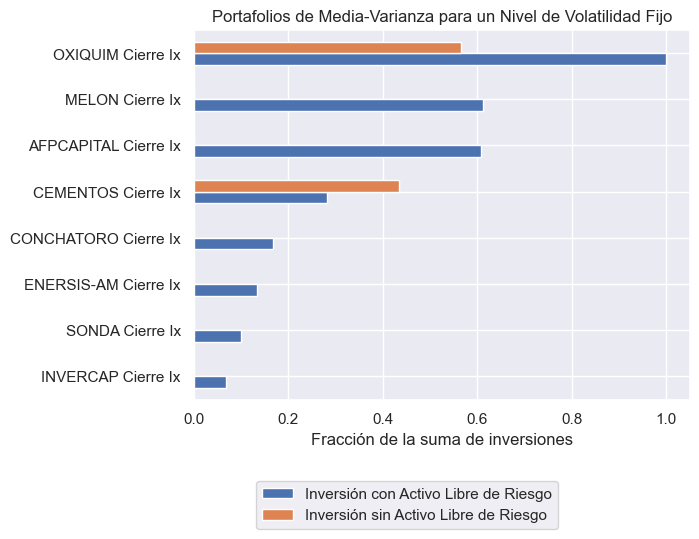

In [22]:
# Ajustar restricciones modelo básico
c.lb = 0
c.ub = 0
m.params.OutputFlag = 0
m.optimize()

# Solución
mask = (abs(df["x"]) > 1e-6) | (x.X > 1e-6)
df2 = pd.DataFrame(
    index=df["x"][mask].index,
    data={
        "Inversión con Activo Libre de Riesgo": df["x"],
        "Inversión sin Activo Libre de Riesgo": x.X[mask],
    },
).sort_values(by=["Inversión con Activo Libre de Riesgo"], ascending=True)

axs = df2.plot.barh()
axs.set_xlabel("Fracción de la suma de inversiones")
plt.title("Portafolios de Media-Varianza para un Nivel de Volatilidad Fijo")
plt.legend(bbox_to_anchor=(0.75, -0.2))
plt.show()

## Frontera Eficiente

La frontera eficiente revela el equilibrio entre riesgo y retorno en los portafolios de inversión. Muestra el mejor nivel de retorno esperado que se puede lograr para un nivel de riesgo específico.

In [23]:
# Extraer la diagonal
diagonal = np.sqrt(np.diag(Sigma))

# Mejor índice en términos de retorno
indice_mayor_mu = np.argmax(mu)

riesgos = np.linspace(0, 4.5, 50)

rf_bnds = [(0, 0), (-np.inf, np.inf)]

retornos = pd.DataFrame(index=riesgos)

# prevenir el output
m.params.OutputFlag = 0

for lb, ub in rf_bnds:
    name = f"[{lb}, {ub}]"
    c.LB = lb
    c.UB = ub

    r = np.zeros(riesgos.shape)
    # Resolver
    for i, risk_level in enumerate(riesgos):
        # Actualizamos el nivel de riesgo
        restriccion_riesgo.QCRHS = risk_level**2

        m.optimize()
        if m.Status == gp.GRB.OPTIMAL:
            r[i] = m.ObjVal
        else:
            r[i] = float("NaN")

    retornos[name] = r

A continuación, mostramos la frontera eficiente para ambas estrategias: graficamos los rendimientos esperados (en el eje $y$) frente a la desviación estándar $\sqrt{x^\top\Sigma x}$ de los rendimientos esperados (en el eje $x$).

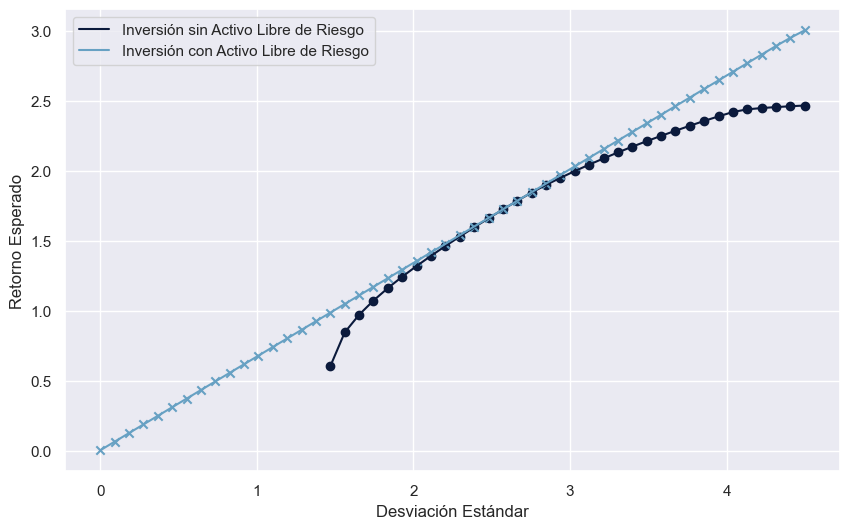

In [24]:
colors = ["#0b1a3c", "#67a1c3", "#f6c105", "#dd2113"]
markers = ["o", "x", "x", "x"]
fig, axs = plt.subplots(figsize=(10, 6))

for column, color, marker in zip(retornos.columns, colors, markers):
    axs.scatter(x=retornos.index, y=retornos[column], marker=marker, color=color)
    label = (
        "Inversión sin Activo Libre de Riesgo"
        if column == "[0, 0]"
        else f"Inversión con Activo Libre de Riesgo"
    )
    axs.plot(
        retornos.index,
        retornos[column],
        label=label,
        color=color,
    )
axs.set_xlabel("Desviación Estándar")
axs.set_ylabel("Retorno Esperado")
axs.legend()

plt.show()

Si permitimos invertir en un activo libre de riesgo, la varianza del portafolio puede ser arbitrariamente pequeña. Si se invierte todo el capital en el activo libre de riesgo, la varianza (y la desviación estándar) es 0.

Si permitimos un mayor riesgo, incluyendo la posibilidad de pedir prestado dinero, esto desplaza la frontera eficiente hacia mayores retornos.

## Análisis de la Solución

Para encontrar el portafolio que entrega el mayor retorno esperado para cualquier volatilidad, hay que encontrar la recta con mayor pendiente.

Eso es equivalente a maximizar la expresión:

$$\text{Sharpe Ratio} = \frac{𝐸[𝑟_𝑝 ]−𝑟_𝑓}{𝜎(𝑟_𝑝 )}$$

El portafolio con mayor Sharpe Ratio está donde la recta que pasa por el activo libre de riesgo es tangente a la frontera eficiente.

El portafolio que genera esta recta tangente es conocido como portafolio tangente.

Obtengamos el portafolio tangente de forma alternativa:

In [25]:
# Extraer la diagonal
diagonal = np.sqrt(np.diag(Sigma))

# Mejor índice en términos de retorno
indice_mayor_mu = np.argmax(mu)

riesgos = np.linspace(0, 4.5, 50)

rf_bnds = [(-np.inf, np.inf)]

soluciones = np.zeros(shape=(50, len(mu)))

# prevenir el output
m.params.OutputFlag = 0

for lb, ub in rf_bnds:
    name = f"[{lb}, {ub}]"
    c.LB = lb
    c.UB = ub

    # Resolver
    for i, risk_level in enumerate(riesgos):
        # Actualizamos el nivel de riesgo
        restriccion_riesgo.QCRHS = risk_level**2

        m.optimize()
        if m.Status == gp.GRB.OPTIMAL:
            soluciones[i] = x.X
        else:
            pass

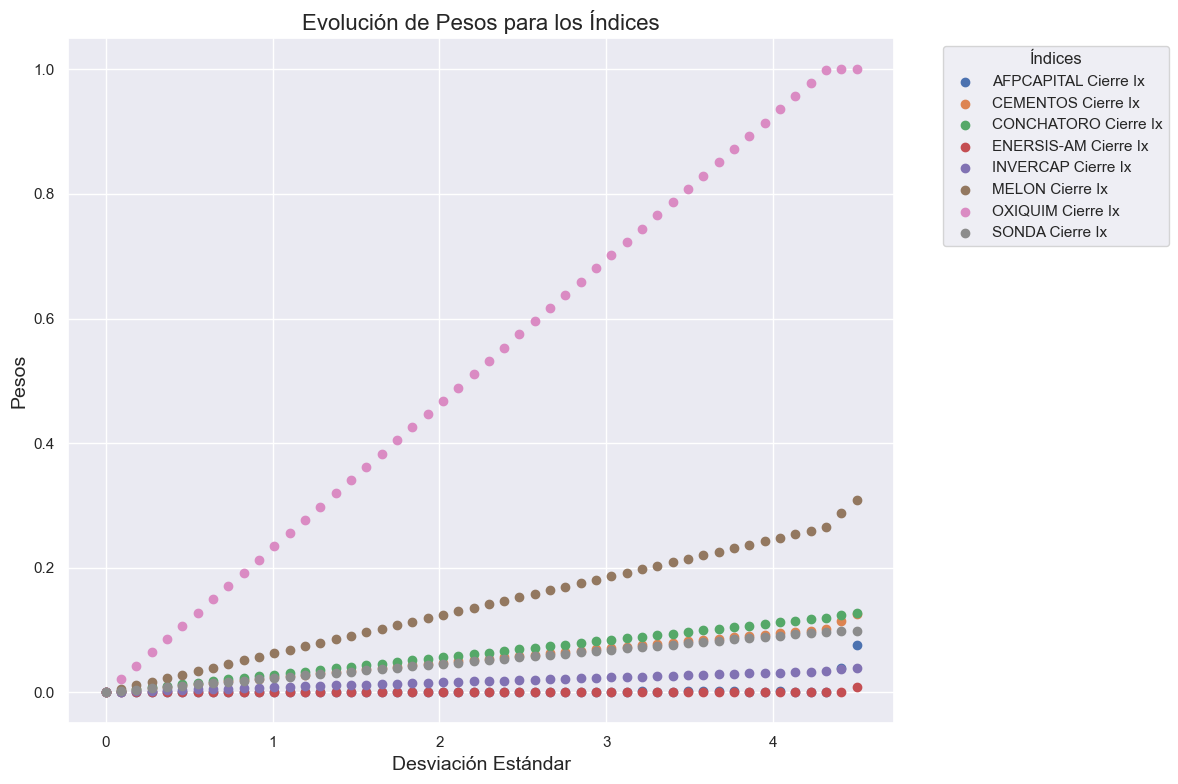

In [26]:
# Graficar la evolución de precios para todos los índices
plt.figure(figsize=(12, 8))

nombres = list(mu.index)

# Graficar todas las columnas (activos)
for i in range(len(nombres)):
    plt.scatter(x=retornos.index, y=soluciones[:, i], label=nombres[i])

# Añadir título y etiquetas
plt.title('Evolución de Pesos para los Índices', fontsize=16)
plt.xlabel('Desviación Estándar', fontsize=14)
plt.ylabel('Pesos', fontsize=14)
plt.grid(True)
plt.legend(title='Índices', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

Se observa un comportamiento lineal en los pesos del portafolio, en la medida que aumenta la volatilidad

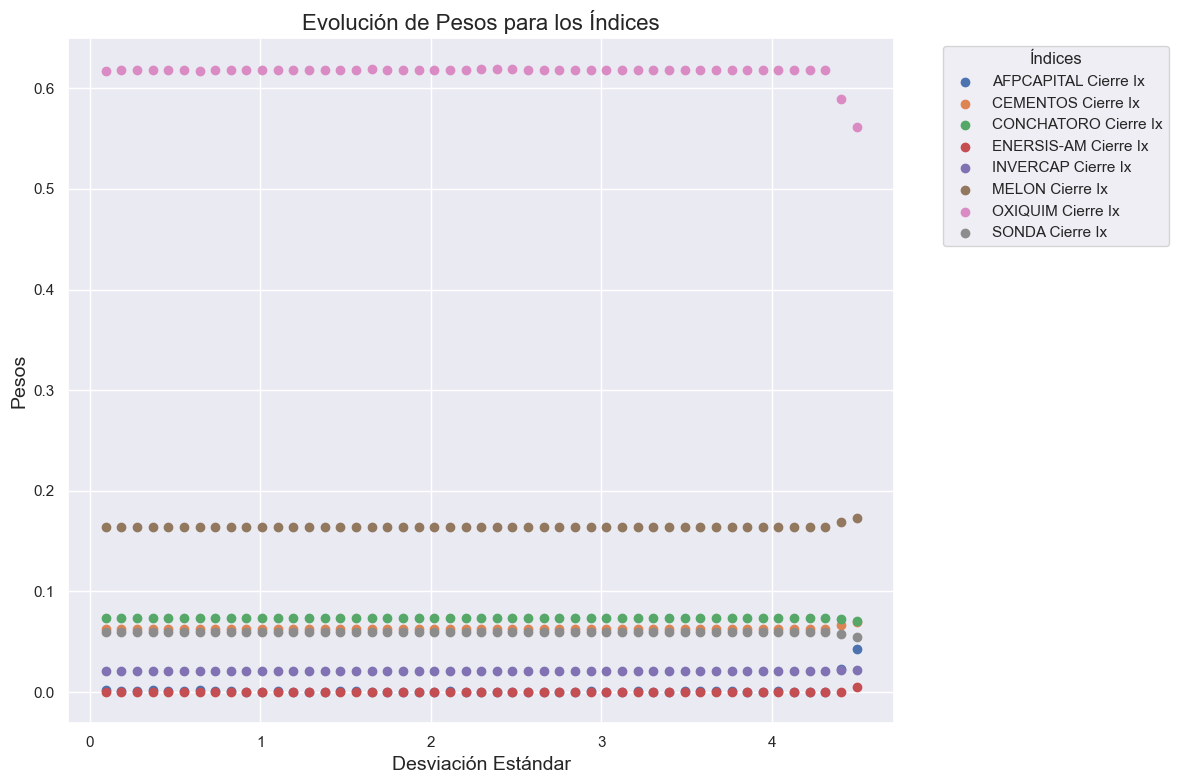

In [27]:
soluciones_normalizadas = soluciones / soluciones.sum(axis=1).reshape(-1, 1)

# Graficar la evolución de precios para todos los índices
plt.figure(figsize=(12, 8))

nombres = list(mu.index)

# Graficar todas las columnas (activos)
for i in range(len(nombres)):
    plt.scatter(x=retornos.index[1:], y=soluciones_normalizadas[1:, i], label=nombres[i])

# Añadir título y etiquetas
plt.title('Evolución de Pesos para los Índices', fontsize=16)
plt.xlabel('Desviación Estándar', fontsize=14)
plt.ylabel('Pesos', fontsize=14)
plt.grid(True)
plt.legend(title='Índices', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [28]:
df = pd.DataFrame({'Peso': soluciones_normalizadas[-1, :]}, index=nombres).round(6)
df

,Peso
AFPCAPITAL Cierre Ix,0.042662
CEMENTOS Cierre Ix,0.070022
CONCHATORO Cierre Ix,0.071124
ENERSIS-AM Cierre Ix,0.004663
INVERCAP Cierre Ix,0.021660
MELON Cierre Ix,0.173443
OXIQUIM Cierre Ix,0.561338
SONDA Cierre Ix,0.055089


Estandarizando los resultados, se determina que los pesos son constantes. Estudiemos gráficamente el resultado:

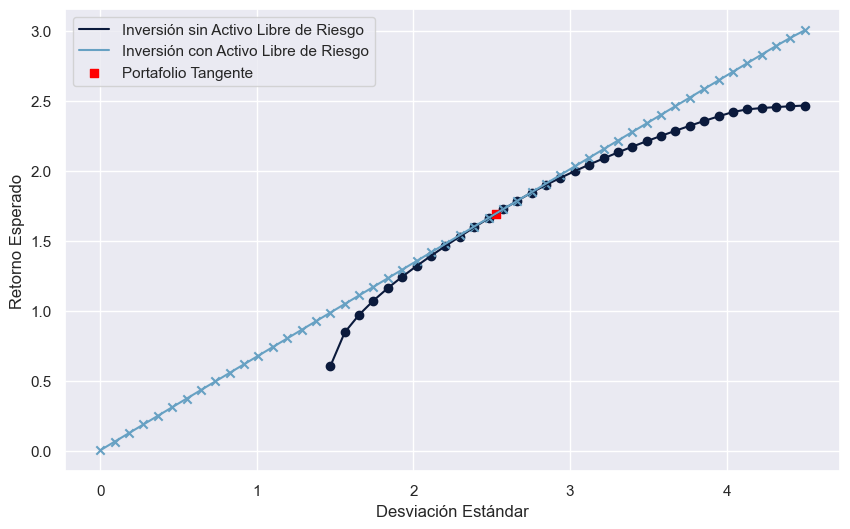

In [29]:
colors = ["#0b1a3c", "#67a1c3", "#f6c105", "#dd2113"]
markers = ["o", "x", "x", "x"]
fig, axs = plt.subplots(figsize=(10, 6))

weights = soluciones_normalizadas[-1, :]

retorno_tangente = np.dot(weights, mu)
volatilidad_tangente = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))

for column, color, marker in zip(retornos.columns, colors, markers):
    axs.scatter(x=retornos.index, y=retornos[column], marker=marker, color=color)
    label = (
        "Inversión sin Activo Libre de Riesgo"
        if column == "[0, 0]"
        else f"Inversión con Activo Libre de Riesgo"
    )
    axs.plot(
        retornos.index,
        retornos[column],
        label=label,
        color=color,
    )

axs.scatter(x=volatilidad_tangente, y=retorno_tangente, marker="s", color="Red", label="Portafolio Tangente")

axs.set_xlabel("Desviación Estándar")
axs.set_ylabel("Retorno Esperado")
axs.legend()

plt.show()